<h1 style="text-align: center;">✨THE LUSCHER ZETA FUNCTION✨</h1>


Our function:

$$
\mathcal{Z}_{0,0}(1; \tilde{q}^2) = \sum_{ } \left( \frac{1}{|\mathbf{n}|^2 - \tilde{q}^2} - \frac{1}{|\mathbf{n}|^2} \right)
$$

where:

- $ \mathbf{n} = (x, y, z) $ are integer lattice vectors inside a cubic box.
- $ |\mathbf{n}|^2 = x^2 + y^2 + z^2 $ is the squared norm of the lattice points.
- The term $ \frac{1}{|\mathbf{n}|^2 - \tilde{q}^2} $ defines the main sum.
- The subtraction $ - \frac{1}{|\mathbf{n}|^2} $ removes the divergence at $ \tilde{q}^2 = 0 $.

This function arises in **Lüscher’s finite-volume method**, where it is used to relate the discrete finite-volume energy levels of a two-particle system in a periodic box to the infinite-volume **scattering phase shifts**. Let's code this!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange  # makes it compile faster

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The infinite sum term of the Luscher Zeta function. For this we are doing a **Pavé summation**.

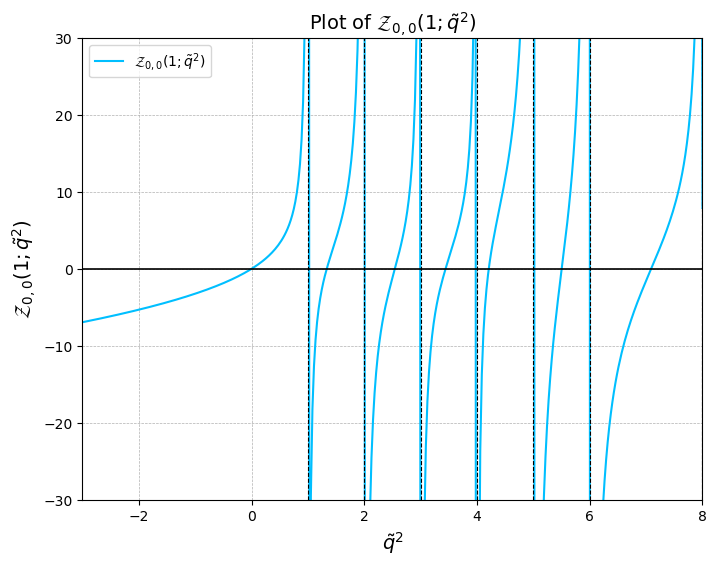

In [2]:
@njit
def norm_squared(x, y, z):
    return x*x + y*y + z*z


@njit(parallel=True)  # Parallel execution across multiple CPU cores
def Z_00(q2, L_max, epsilon=1e-6):
    """
    Compute the Lüscher zeta function Z_{0,0}(1; q^2).
    """
    Z_value = 0.0 + 0.0j  # Initialise sum

    for x in prange(-L_max, L_max + 1):  # Prange for parallel execution
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                if x == 0 and y == 0 and z == 0:
                    continue
                r2 = norm_squared(x, y, z)
                denominator = (r2 - q2) + epsilon * 1j
                Z_value += (1.0 / denominator) - (1.0 / r2)  # Subtract divergence term

    return Z_value.real / np.sqrt(4 * np.pi)  # Paper's normalisation

# Define the function for computing Z_00 for a range of q² values
def compute_Z_00_for_q2(q2, L_max, epsilon):
    return Z_00(q2, L_max, epsilon)

# Define range of q^2 values
q2_values = np.linspace(-3, 8, 400)
Z_values = [compute_Z_00_for_q2(q2, L_max=30, epsilon=1e-6) for q2 in q2_values]

# Compute unique squared norms for vertical dashed lines
@njit
def generate_lattice_points(L_max):
    unique_squared_norms = set()
    for x in range(-L_max, L_max + 1):
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                if x == 0 and y == 0 and z == 0:
                    continue
                unique_squared_norms.add(norm_squared(x, y, z))
    return sorted(unique_squared_norms)

# Lattice energy levels
n_squared_values = generate_lattice_points(L_max=30)

# Plot the function
plt.figure(figsize=(8, 6))

# Main plot (light blue)
plt.plot(q2_values, Z_values, color='deepskyblue', linewidth=1.5, label=r'$\mathcal{Z}_{0,0}(1; \tilde{q}^2)$')

# x-axis (black)
plt.axhline(0, color='black', linewidth=1.2)

# Vertical dashed lines at non-interacting energy levels
for n2 in n_squared_values:
    plt.axvline(n2, color='k', linestyle='dashed', linewidth=0.8)

# Plot formatting
plt.xlabel(r'$\tilde{q}^2$', fontsize=14)
plt.ylabel(r'$\mathcal{Z}_{0,0}(1; \tilde{q}^2)$', fontsize=14)
plt.title(r'Plot of $\mathcal{Z}_{0,0}(1; \tilde{q}^2)$', fontsize=14)
plt.ylim(-30, 30)
plt.xlim(-3, 8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


Our plot follows the expected trend but the positions of the poles (divergences) do not align with the correct plot (in https://arxiv.org/pdf/1101.3347). (Currently working on figuring out why, possible reasons include a different overall factor in the equation, ).

Higher L_max values were tested: The code above has L_max = 30 and takes 5s to run. The code below has L_max = 100 but otherwise identical takes 20s to run but the graoh looks identical.

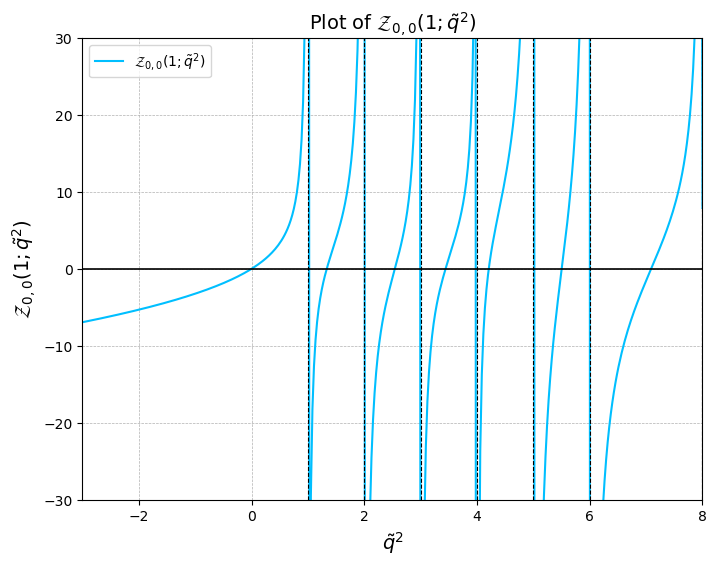

In [3]:
@njit
def norm_squared(x, y, z):
    return x*x + y*y + z*z

@njit(parallel=True)  # Parallel execution across multiple CPU cores
def Z_00(q2, L_max, epsilon=1e-6):
    """
    Compute the Lüscher zeta function Z_{0,0}(1; q^2) with divergence subtraction.
    """
    Z_value = 0.0 + 0.0j  # Initialise sum

    for x in prange(-L_max, L_max + 1):  # Prange for parallel execution
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                if x == 0 and y == 0 and z == 0:
                    continue
                r2 = norm_squared(x, y, z)
                denominator = (r2 - q2) + epsilon * 1j
                Z_value += (1.0 / denominator) - (1.0 / r2)  # Subtract divergence term

    return Z_value.real / np.sqrt(4 * np.pi)  # Paper's normalisation

# Define the function for computing Z_00 for a range of q² values
def compute_Z_00_for_q2(q2, L_max, epsilon):
    return Z_00(q2, L_max, epsilon)

# Define range of q^2 values
q2_values = np.linspace(-3, 8, 400)
Z_values = [compute_Z_00_for_q2(q2, L_max=30, epsilon=1e-6) for q2 in q2_values]  # 🚀 Much faster now

# Compute unique squared norms for vertical dashed lines
@njit  # 🚀 JIT this function for instant speedup
def generate_lattice_points(L_max):
    unique_squared_norms = set()
    for x in range(-L_max, L_max + 1):
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                if x == 0 and y == 0 and z == 0:
                    continue
                unique_squared_norms.add(norm_squared(x, y, z))
    return sorted(unique_squared_norms)

# Lattice energy levels
n_squared_values = generate_lattice_points(L_max=100)

# Plot the function
plt.figure(figsize=(8, 6))

# Main plot (light blue)
plt.plot(q2_values, Z_values, color='deepskyblue', linewidth=1.5, label=r'$\mathcal{Z}_{0,0}(1; \tilde{q}^2)$')

# x-axis black
plt.axhline(0, color='black', linewidth=1.2)

# Vertical dashed lines at non-interacting energy levels
for n2 in n_squared_values:
    plt.axvline(n2, color='k', linestyle='dashed', linewidth=0.8)  # Thinner lines for better clarity

# Plot formatting
plt.xlabel(r'$\tilde{q}^2$', fontsize=14)
plt.ylabel(r'$\mathcal{Z}_{0,0}(1; \tilde{q}^2)$', fontsize=14)
plt.title(r'Plot of $\mathcal{Z}_{0,0}(1; \tilde{q}^2)$', fontsize=14)
plt.ylim(-30, 30)
plt.xlim(-3, 8)
plt.grid(True, linestyle='--', linewidth=0.5)  # 🚀 Cleaner grid
plt.legend()
plt.show()
